# Predicting King-County Home Selling Price with Regression #

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os

## Load Data

In [2]:
#Get Data from ../DataScience/Data Sets/
head, tail = os.path.split(os.getcwd())
path = head + '/Data Sets/kc_house_data.csv'

#Create Pandas Data Frame
data = pd.read_csv(path)
var_names = data.columns.values

print 'Data Variables = %s' %var_names

Data Variables = ['id' 'date' 'price' 'bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot'
 'floors' 'waterfront' 'view' 'condition' 'grade' 'sqft_above'
 'sqft_basement' 'yr_built' 'yr_renovated' 'zipcode' 'lat' 'long'
 'sqft_living15' 'sqft_lot15']


If we look at the variable names and explore the data a bit further we can notice that the variables `id` and `date` don't give us any useful information. Thus we will dump them from the data matrix. 

In [3]:
data = data.drop(['id','date'], axis=1)
var_names = data.columns.values

## Simple Linear Regression to Start ##
Let's start with something simple. Though our goal is to eventually perform multiple linear regression, we will start by performing simple linear regression on one of the variables. After playing around with some plots, I decided to start out by using the amount of total square feet of the house as a predictor for the price. This seems like a natural place to start, since there is likely an approximately linear relationship between the amount of square feet for a given house and its respective value (i.e. its selling price).

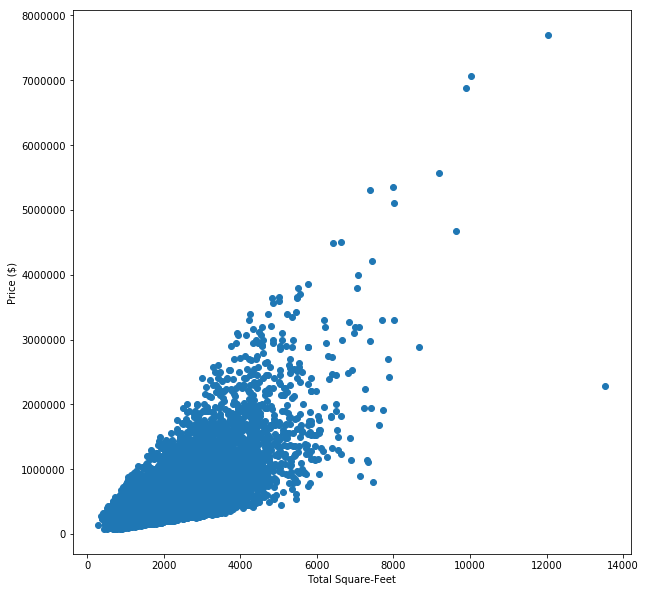

In [4]:
sqft = np.array(data.sqft_living).reshape(-1,1)
price = np.array(data.price).reshape(-1,1)

plt.figure(figsize=(10,10))
plt.scatter(sqft, price)
plt.xlabel('Total Square-Feet')
plt.ylabel('Price ($)')

As we can see the data is not exactly linear, but it does appear that simple linear regression will do a fairly decent job at capturing the relationship between square feet and price. We can see that there are some outliers however, most notably the point with the largest value of square-feet. Maybe this house was a farm or some property that is isolated, which could lead to its value being lower than expected.

## Building the Model ##
Let's start by splitting the data into training and testing sets using scikit learns built-in function [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from the `model_selection` module (click `train_test_split` to see the functions documentation):

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(sqft, price, test_size = 0.33, random_state=24)

#Create Linear Regression Object
regr = linear_model.LinearRegression()

#Fit Model to Training Data
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

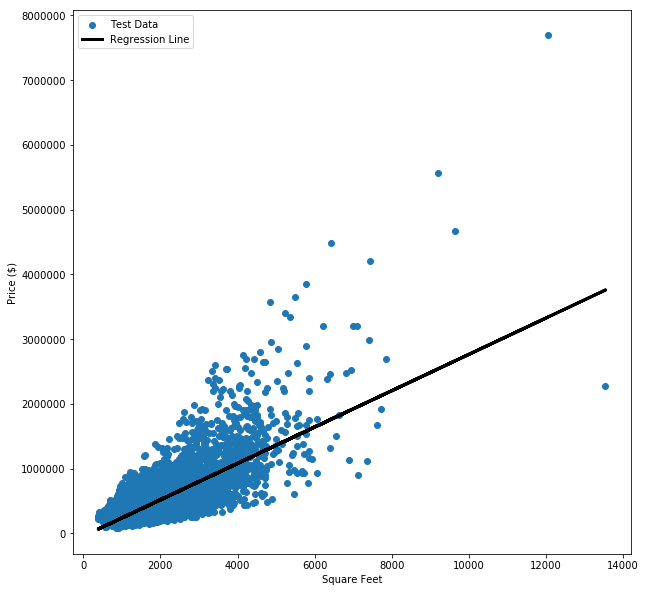

In [6]:
#Plot Predictions
plt.figure(figsize=(10,10))
test_plot = plt.scatter(X_test, y_test)
pred_line, = plt.plot(X_test, regr.predict(X_test), 'k', linewidth=3)
plt.xlabel('Square Feet')
plt.ylabel('Price ($)')
plt.legend([test_plot, pred_line], ['Test Data', 'Regression Line'])
plt.show()

## Interpreting the Results ##
From a visual perspective it looks like the model roughly fits the data, but lets quantify how well the model actually works. To do so we perform the standard analysis for simple linear regression wherein we compute the mean squared error as well as the explained variance score.

In [7]:
#Mean Square Error
print 'Mean Square Error = %.4f' % np.mean((regr.predict(X_test) - y_test) ** 2)

#Expected Variance
print 'Variance Score = %.4f' % regr.score(X_test, y_test)

Mean Square Error = 66853156070.2421
Variance Score = 0.5049


As we can see the mean-squared error is pretty huge, but since the variance score is about 0.5 we can conclude that the simple linear regression describes the overall structure of the data pretty well. 

Now that we have built a basic model, let's work on extending our model to include more of the features of the dataset. To do so we will select a subset of the variables that are highly correlated to the selling price of the house. Something to bear in mind here is that a large portion of our variables take on discrete values (e.g. 3 bedrooms or 2 bathrooms). Thus our linear model will take on values outside of the datas domain, but this is not a huge problem since when we actually apply our model for prediction we will never use values outside of the data's domain. 

We will come back to this idea in a bit, but first let's find out how the variables correlate with price (for now ignoring whether the data is not continuous). 

In [8]:
data.corr().price.sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
zipcode         -0.053203
Name: price, dtype: float64

This all seems pretty reasonable, aside from my surprise that the `grade` variable turned out to have the second highest correlation score. It turns out my surprise was mostly due to my ignorance of what the grade of a house is. A quick google search quickly cleared up my confusion. I learned that in King County the grade of a house is a measure  of construction quality. Makes sense, higher priced homes likely have a higher quality of construction. From the King County website:
>Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value.

So now we have to choose which features to use for our multiple regression. We could use all of the features, since there are only 18, but the point of building a simple model is to use less data! If we used each of the features to build a model, we will probably end up overfitting.

What should we do? I am no expert here so my intuition says just play around a bit and see what happens. I'll start by taking the top 5 features correlating to price (why 5? I dunno just becuase!). So that means we are going to build our first multiple regression model with the features `sqft_living`, `grade`, `sqft_above`, `sqft_living15`, `bathrooms`.


In [9]:
#Create Multiple Regression Object
mult_regr = linear_model.LinearRegression()

#Split Data Into Training/Testing
features = ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms']

X_mult_train, X_mult_test, y_mult_train, y_mult_test = train_test_split(
    data[features], price, test_size = 0.33, random_state=42)


#Fit Model
mult_regr.fit(X_mult_train, y_mult_train)

#Check Regression Score
mult_regr.coef_
print 'Variance score = %r' %mult_regr.score(X_mult_test, y_mult_test)

Variance score = 0.53801173583807771


Observe that the variance score has increased from our previous simple linear regression, but its hardly much better. So we have built a better model, but the amount of increase in our prediction ability has only marginally increased. This suggests that we should try either adding in some more features or using other techniques to build a more effective model.

Let's see what happens if we use all of the features. Since there are 18 features we have the computational power to do this!

In [10]:
#Model With Every Feature!
mult_regr_all = linear_model.LinearRegression()

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(
    data.drop('price',axis=1), price, test_size=0.33, random_state=45)

#Fit Er Done!
mult_regr_all.fit(X_all_train, y_all_train)

#Check Results
print 'Variance score = %r' %mult_regr_all.score(X_all_test, y_all_test)

Variance score = 0.69966344828352922


As expected the variance score has increased significantly! We could go through and start getting rid of features at this point, but instead I am more interested in trying out some different models. It's also worth bearing in mind that as we add in more features our variance score is expected to increase. Our final multiple linear regression model does a decent job of prediction, but I am convinced that we can do better.

To sum up so far: here are the variance scores we achieved in our first 3 attempts. All in all it appears that we have a good benchmark to gauge further analysis on.

In [11]:
print 'Simple Linear Model     : %r' %regr.score(X_test, y_test)
print 'Multiple Linear Model 1 : %r' %mult_regr.score(X_mult_test, y_mult_test)
print 'Multiple Linear Model 2 : %r' %mult_regr_all.score(X_all_test, y_all_test)

Simple Linear Model     : 0.50492539726572938
Multiple Linear Model 1 : 0.53801173583807771
Multiple Linear Model 2 : 0.69966344828352922


# More To Come.....!